<a href="https://colab.research.google.com/github/pabloapablaza/StyleTransfer/blob/main/Style_Transfer_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##**Proyecto Style Transfer**
#####**EL4106 Inteligencia Computacional**



En este proyecto se busca implementar un algoritmo de transferencia de estilo de imágenes, en base al trabajo *A Neural Algorithm of Artistic Style*, el cual realiza el trabajo en base a redes neuronales convolucionales.

El trabajo se realiza principalmente utilizando la librería Tensorflow 2, a partir de un modelo pre-entrenado de la red neuronal convolucional VGG19 provista por Keras.

###**Importar librerias y cargar imagenes** 

####**Cargar librerias**

In [1]:
#Importar librerias
import os
import tensorflow as tf
import IPython.display as display
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import PIL.Image
import time
import functools
from google.colab import files
import time

In [2]:
#Importar modelo red VGG19 de Keras
import tensorflow.keras.applications.vgg19 as vgg19

####**Funciones utiles para cargar y graficar imagenes**

In [3]:
def tensor_to_image(tensor):

  """Funcion que permite pasar de tensor (4D) a imagen (3D).
  Se reducen las dimensiones de la imagen y se multiplica por 255 el
  valor del tensor para pasar a valores RGB"""

  tensor = tensor*255
  tensor = np.array(tensor, dtype=np.uint8)

  if np.ndim(tensor)>3:
    assert tensor.shape[0] == 1
    tensor = tensor[0]
    
  return PIL.Image.fromarray(tensor)

In [4]:
def load_img(path):

  """Carga las imagenes especificadas en path y reescala con tal 
  que la dimension mas larga sea de 512px"""

  max_dim = 512
  img = tf.io.read_file(path)
  img = tf.image.decode_image(img, channels = 3)
  img = tf.image.convert_image_dtype(img, tf.float32)

  shape = tf.cast(tf.shape(img)[:-1], tf.float32)
  long_dim = max(shape)
  scale = max_dim / long_dim

  new_shape = tf.cast(shape * scale, tf.int32)

  img = tf.image.resize(img, new_shape)
  img = img[tf.newaxis, :]
  return img

In [5]:
def plot_img(image, title=None):

  """Funcion para graficar las imagenes cargadas"""

  if len(image.shape) > 3:
    image = tf.squeeze(image, axis=0)

  plt.imshow(image)
  if title:
    plt.title(title)

In [6]:
def plot_pairs(content, style, dims):

  """Grafica pares de imagenes para mostrar contenido y estilo juntos con la dimension
  especificada"""

  if content !=None and style!=None:
    plt.figure(figsize = (dims, dims))

    plt.subplot(1, 2, 1)
    plot_img(content, 'Imagen de contenido')

    plt.subplot(1, 2, 2)
    plot_img(style, 'Imagen de estilo')

###**Modelo de red VGG19** 

####**Construcción modelo VGG19**

Se define una función que permite extraer las capas del modelo VGG19, de manera de poder utilizarlas para extracción de estilo y extracción de características en base a las listas *content_lay* y *style_lay*, en las cuales se encuentran las capas a utilizar para contenido y estilo. 

In [7]:
def vgg_layers(lay_names):

  """Funcion que retorna las capas seleccionadas del modelo VGG19 dentro de la 
  lista lay_names.
  
  Esta funcion permite las capas para extraccion de estilo y características"""

  #Modelo preentrenado VGG19
  vgg = tf.keras.applications.VGG19(include_top = False, weights = 'imagenet', pooling='avg') 
  vgg.trainable = False

  #Lista con las capas requeridas según estilo o contenido
  salidas = [vgg.get_layer(name).output for name in lay_names]

  model = tf.keras.Model([vgg.input], salidas)
  return model

A continuación, se define el extractor de caracteristicas en base a la funcion *vgg_layers*, la cual crea el modelo en base a las capas para extraer caracteristicas.

Con el modelo creado, se utiliza como input a la imagen de estilo *style_img*, la cual se procesa en el modelo. 

###**Error y estilo** 

Se calcula la **matriz de gram** para medir la correlación entre los *feature maps* de las capas convolucionales obtenidas para el estilo.

In [9]:
class ContenidoyEstilo(tf.keras.models.Model):

  #Input son las capas de contenido y estilo (las necesarias para el modelo)
  def __init__(self, style_layers, content_layers): 
    super(ContenidoyEstilo, self).__init__()

    """Se definen las variables de la clase"""

    self.vgg = vgg_layers(style_layers + content_layers) #Capas convolucionales del modelo
    self.style_layers = style_layers #Capas de estilo
    self.content_layers = content_layers #Capas de contenido
    self.num_style_layers = len(style_layers) #Cantidad de capas de estilo
    self.vgg.trainable = False #Modelo no entrenable

  def gram(self, input):

    """Calcula la matriz de Gram (Gram matrix) para el tensor de entrada (input)"""

    matrix = tf.linalg.einsum('bijc, bijd->bcd', input, input) #Computar 
    input_shape = tf.shape(input)
    cte = tf.cast(input_shape[1] * input_shape[2], tf.float32)
    result = matrix/cte #Se divide por la cantidad de pixeles. Se obtiene el resultado.
    return result

  def call(self, inputs):
    inputs =  inputs * 255.0 #La imagen viene en [0,1] por lo que se pasa a RGB
    #Preprocesar la entrada con la funcion de Keras 
    preproc_input = tf.keras.applications.vgg19.preprocess_input(inputs)

    outputs = self.vgg(preproc_input) #Procesar la entrada preprocesada en el modelo vgg.

    #Capas de estilo y de contenido a partir del modelo VGG19
    style_out, content_out = (outputs[:self.num_style_layers],
                              outputs[self.num_style_layers:])
    
    #Se calcula la matriz de gram para el estilo
    style_out = [self.gram(style_out) for style_out in style_out]
    
    #Diccionario con el nombre de la capa de contenido y el valor del tensor
    content_dict = {content_name: value for content_name, value in zip(self.content_layers,
                                                                       content_out)}

    #Diccionario con los nombres de las capas de estilo y valores de tensores
    style_dict = {style_name: value for style_name, value in zip(self.style_layers,
                                                                  style_out)}
    content_n_style = {'content': content_dict, 'style': style_dict}
    return content_n_style

Se define la ecuación (1) del paper, que corresponde a la función de costos que relaciona la imagen original con la imagen generada. En particular, $P^{l}$ y $F^{l}$ son las representaciones de caracteristicas en la capa $l$:

$$\mathcal{L}_{content} (\vec{p},\vec{x},l)=\frac{1}{2}\sum_{i, j} (F_{ij}^{l}-P_{ij}^{l})$$



*   $\vec{p}$ imagen original.
*   $\vec{x}$ imagen generada.
*   $l$ capa donde se calcula el costo.

Ahora se define la ecuación (5) del paper, la cual corresponde a la función de costos para el estilo:

$$\mathcal{L}_{style} (\vec{a},\vec{x})=\sum_{l=0}^{L} w_{l}E_{l}$$

* $\vec{a}$ es la imagen original.
* $\vec{x}$ es la imagen que es generada a partir del estilo.
*   $w_{l}$ son los factores de la contribución de cada capa a la función de costos. **Estos parámetros son importantes ya que ajustan los resultados del modelo** pues 'pesan' la contribución de cada capa al error. 

Además, $E_{l}$ es la contribución de cada capa al error total. Esté parámetro está dado por:

$$E_{l}=\sum_{i,j}(G_{ij}^{l}-A_{ij}^{l})^{2}$$

$$L_{total}=\alpha\mathcal{L}_{content}+\beta\mathcal{L}_{style}$$







###**Entrenamiento y resultados** 

In [10]:
class StyleTransfer():

  def __init__(self, style_img, content_img, style_weight, 
               content_weight, style_weights,it_epoch, n_epochs, style_layers, content_layers):

      #style_img: imagen de estilo
      #content_img: imagen de contenido
      #opt_img: imagen a optimizar
      #style_weight: peso del estilo
      #content_weigt: peso del contenido
      #style_weights: peso de las capas de estilo
      #it_epoch: iteraciones por epoca
      #n_epoch: numero de epocas
      #style_layers: capas usadas para estilo
      #content_layers: capas usadas para contenido

    """Se definen las variables de la clase"""

    self.style_img = style_img #imagen de estilo
    self.content_img = content_img #imagen de contenido
    self.train_img = tf.Variable(self.content_img) #variable a entrenar

    self.style_weight = style_weight #peso de estilo beta
    self.content_weight = content_weight #peso de contenido alpha
    self.style_weights = style_weights #peso de cada capa de estilo w

    self.style_layers = style_layers #capas de estilo
    self.content_layers = content_layers #capas de contenido

    self.extractor = ContenidoyEstilo(self.style_layers, self.content_layers) #extraer capas de contenido y estilo
    self.style_target = self.extractor(self.style_img)['style'] #extraer capas de estilo
    self.content_target = self.extractor(self.content_img)['content'] #extraer capas de contenido

    self.optimizer = tf.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1) #optimizador a ocupar.
    self.it_epoch = it_epoch #iteraciones por epoca
    self.n_epochs = n_epochs #numero de epocas 
  
  def clip_01(self, img):
    """Funcion para mantener los valores del tensor entre 0 y 1"""
    clip = tf.clip_by_value(img, 0.0, 1.0)
    return clip

  def style_content_loss(self, outputs): #outputs es la salida de la capa convolucional
  
    """Funcion en la cual se calcula el error total en base a la funcion de costos 
    definida en el paper. Los pesos se modifican en las variables del chunk anterior"""
    
    style_outputs = outputs['style'] #estilo extraido de la imagen de entrada
    content_outputs = outputs['content'] #caracteristicas extraidas de la imagen de entrada.

    style_loss = tf.add_n([self.style_weights[name]*tf.reduce_mean((style_outputs[name]-self.style_target[name])**2) 
                          for name in style_outputs.keys()])
    
    style_loss *= self.style_weight 

    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-self.content_target[name])**2) 
                            for name in content_outputs.keys()])
    
    content_loss *= self.content_weight
    
    loss = style_loss + content_loss
    return loss

  @tf.function()
  def train_step(self, image):
    """Funcion que realiza el paso de entrenamiento por gradiente descendente"""
    with tf.GradientTape() as tape:
      #Extraer características
      outputs = self.extractor(image)
      #Calcular el error
      loss = self.style_content_loss(outputs)
    #Determinar los gradientes del error con respecto a la imagen
    grad = tape.gradient(loss, image)
    #Actualizar los gradientes
    self.optimizer.apply_gradients([(grad, image)])
    #mantener valores de los pixeles entre 0 y 1 para ser decodificado como RGB despues
    image.assign(self.clip_01(image))
    #return loss


  def stilyze_img(self):
    "Funcion que realiza la aplicación del estilo a la imagen img"
    start = time.time()

    epochs = self.n_epochs
    iter_x_epoch = self.it_epoch

    step = 0
    for n in range(epochs):
      for m in range(iter_x_epoch):
        step += 1
        self.train_step(self.train_img)
        print(".", end='')
      display.clear_output(wait=True)
      display.display(tensor_to_image(self.train_img))
      print("Train step: {}".format(step))
      
    end = time.time()
    print("Total time: {:.1f}".format(end-start))


###**Subir imagenes y hacer transferencia de estilo** 

In [11]:
#Subir archivos 
files.upload()

In [12]:
#Definir paths donde se encuentran las imagenes
style_path = '/content/derschie.jpg'
content_path = '/content/chiron.jpg'

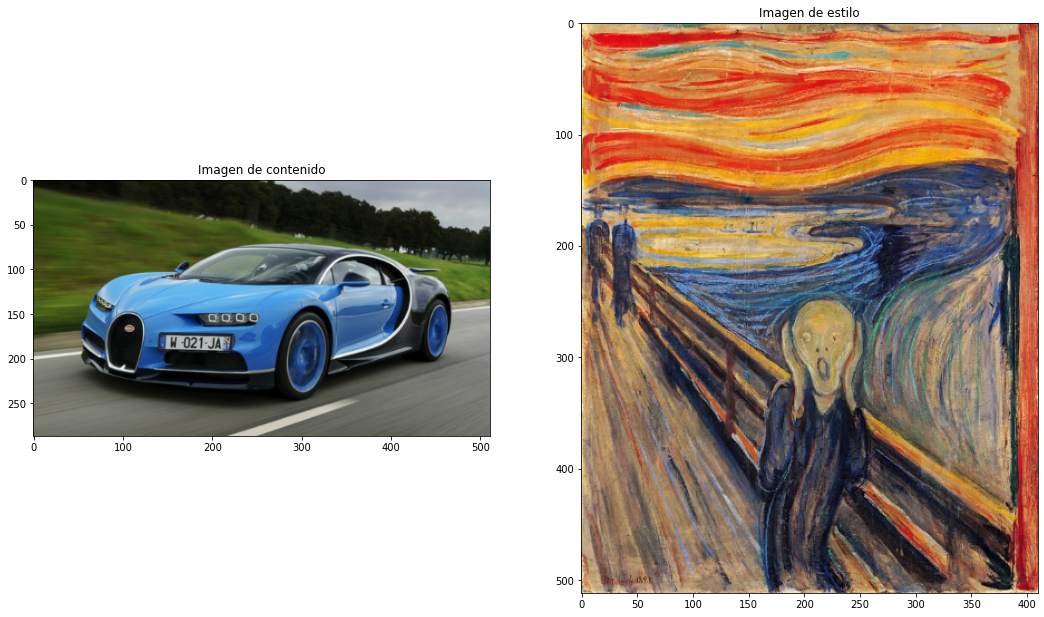

In [13]:
#AJUSTE DE PARÁMETROS

content_img = load_img(content_path) #imagen de contenido
style_img = load_img(style_path) #imagen de estilo

plot_pairs(content_img, style_img, 18) #graficar imagen de contenido y estilo


style_weight=0.003 #beta 
content_weight=1 #alpha
#Hacer dependencia con una variable 
style_weights={'block1_conv1': 0.2, #pesos para las capas en la funcion de style_loss
               'block2_conv1': 0.2,
               'block3_conv1': 0.2,
               'block4_conv1': 0.3,
               'block5_conv1': 0.7}
it_epoch = 100 
n_epochs = 60

content_layers=['block4_conv2']
style_layers=['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1', 'block5_conv1']

In [14]:
#modelo para transferir estilo
transfer = StyleTransfer(style_img,
                         content_img, 
                         style_weight, 
                         content_weight, 
                         style_weights, 
                         it_epoch, 
                         n_epochs, 
                         style_layers, 
                         content_layers) 

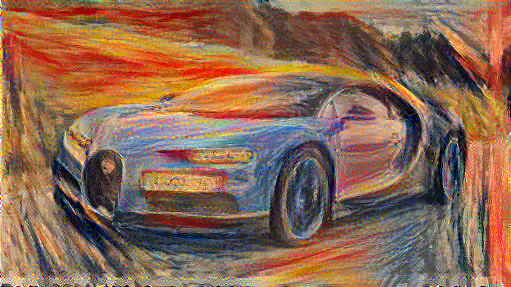

Train step: 6000
Total time: 325.7


In [15]:
#aplicar style transfer en la imagen ya cargada
transfer.stilyze_img()

###Fuentes


*   Gatys L. and Ecker A. and Bethge M. *A Neural Algorithm of Artistic Style*

* [VGG19 Model Keras](https://www.tensorflow.org/api_docs/python/tf/keras/applications/VGG19)

* [Preprocesamiento para VGG19](https://www.tensorflow.org/api_docs/python/tf/keras/applications/vgg19/preprocess_input)
* [Transferencia de estilo neuronal](https://www.tensorflow.org/tutorials/generative/style_transfer)
* [Neural Style Transfer Tutorial](https://towardsdatascience.com/neural-style-transfer-tutorial-part-1-f5cd3315fa7f)
*[Style Transfer Guide](https://www.fritz.ai/style-transfer/#part-basics)
*[Neural Style Transfer: Creating Art with Deep Learning using tf.keras and eager execution](https://medium.com/tensorflow/neural-style-transfer-creating-art-with-deep-learning-using-tf-keras-and-eager-execution-7d541ac31398#:~:text=Neural%20style%20transfer%20is%20an,%2C%20but%20%E2%80%9Cpainted%E2%80%9D%20in%20the)